In [1]:
# --- Standard Library ---
import os
import sys
import json

# --- Google Cloud Auth + APIs ---
from google.cloud import bigquery
from google.oauth2 import service_account
from google.api_core.exceptions import GoogleAPICallError, RetryError

from gspread_dataframe import set_with_dataframe

# --- Data & Visualization ---
import pandas as pd

# --- Local Modules ---
from modules.pull_and_backup import pull_and_append
from modules.flattening import flatten_extract_params, flatten_row, flatten_nested_column
from modules.column_order import column_order

In [2]:
# --- Configuration ---
SERVICE_ACCOUNT_KEY = './keys/key.json'
DATA_PATH = './data/data.json'
PROJECT_ID = "emojioracle-342f1"
DATASET_ID = "analytics_481352676"
BACKUP_PATH = './backup/'
SCOPES = [
    "https://www.googleapis.com/auth/bigquery",
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]
# --- BigQuery Client ---
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_KEY,
    scopes = SCOPES
)
bq_client = bigquery.Client(credentials = credentials, project = PROJECT_ID)

In [3]:
# will pull what is missing from BigQuery and merge into data_path
df = pd.DataFrame(pull_and_append(credentials = credentials, project_id = PROJECT_ID, dataset_id = DATASET_ID, data_path = DATA_PATH, backup_path = BACKUP_PATH))
print(f"Data loaded with {len(df)} rows and {len(df.columns)} columns.")

Loaded existing data.
Latest event_date in merged data: 20250604
Backup already exists: events_20250406
Backup already exists: events_20250407
Backup already exists: events_20250408
Backup already exists: events_20250409
Backup already exists: events_20250410
Backup already exists: events_20250411
Backup already exists: events_20250412
Backup already exists: events_20250413
Backup already exists: events_20250414
Backup already exists: events_20250415
Backup already exists: events_20250416
Backup already exists: events_20250417
Backup already exists: events_20250418
Backup already exists: events_20250420
Backup already exists: events_20250421
Backup already exists: events_20250422
Backup already exists: events_20250423
Backup already exists: events_20250424
Backup already exists: events_20250425
Backup already exists: events_20250427
Backup already exists: events_20250428
Backup already exists: events_20250429
Backup already exists: events_20250430
Backup already exists: events_20250506

In [4]:
# load the data from the JSON file
df = pd.read_json(DATA_PATH)

In [5]:
df.tail()

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,...,event_dimensions,ecommerce,items,collected_traffic_source,is_active_user,batch_event_index,batch_page_id,batch_ordering_id,session_traffic_source_last_click,publisher
19997,20250604,1749061114487007,question_started,"[{'key': 'firebase_conversion', 'value': {'str...",1.749061e+15,NaN,131,331106,NaN,a79d23b40c843fcef55e9a9013b90a35,...,NaN,NaN,[],NaN,False,35,NaN,NaN,{'manual_campaign': {'campaign_id': '(not set)...,NaN
19998,20250604,1749061161990008,question_started,"[{'key': 'firebase_conversion', 'value': {'str...",1.749061e+15,NaN,131,331106,NaN,a79d23b40c843fcef55e9a9013b90a35,...,NaN,NaN,[],NaN,False,38,NaN,NaN,{'manual_campaign': {'campaign_id': '(not set)...,NaN
19999,20250604,1749061294494009,question_started,"[{'key': 'firebase_conversion', 'value': {'str...",1.749061e+15,NaN,131,331106,NaN,a79d23b40c843fcef55e9a9013b90a35,...,NaN,NaN,[],NaN,False,49,NaN,NaN,{'manual_campaign': {'campaign_id': '(not set)...,NaN
20000,20250604,1749061443613010,question_started,"[{'key': 'firebase_conversion', 'value': {'str...",1.749061e+15,NaN,131,331106,NaN,a79d23b40c843fcef55e9a9013b90a35,...,NaN,NaN,[],NaN,False,61,NaN,NaN,{'manual_campaign': {'campaign_id': '(not set)...,NaN
20001,20250604,1749061555770011,question_started,"[{'key': 'firebase_conversion', 'value': {'str...",1.749061e+15,NaN,131,331106,NaN,a79d23b40c843fcef55e9a9013b90a35,...,NaN,NaN,[],NaN,False,71,NaN,NaN,{'manual_campaign': {'campaign_id': '(not set)...,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   event_date                         20002 non-null  int64  
 1   event_timestamp                    20002 non-null  int64  
 2   event_name                         20002 non-null  object 
 3   event_params                       20002 non-null  object 
 4   event_previous_timestamp           19605 non-null  float64
 5   event_value_in_usd                 0 non-null      float64
 6   event_bundle_sequence_id           20002 non-null  int64  
 7   event_server_timestamp_offset      20002 non-null  int64  
 8   user_id                            0 non-null      float64
 9   user_pseudo_id                     20002 non-null  object 
 10  privacy_info                       20002 non-null  object 
 11  user_properties                    20002 non-null  obj

In [7]:
pd.set_option('display.max_columns', None) # uncomment to see all of the cols in pandas dataframes

In [8]:
# flattenning

df = pd.DataFrame([flatten_row(row) for _, row in df.iterrows()]) # for wtfs refer to ./modules/flattening_json.py

In [9]:
# cleaning & preprocessing

## dates and times
df = df.drop(columns=['event_date']) # built in case event_date may not be the same as the one in the event_timestamp

# convert unix time to ape-friendly datetime format
df['time_delta'] = pd.to_datetime(df['event_timestamp'], unit='us', utc=True) - pd.to_datetime(df['event_previous_timestamp'], unit='us', utc=True)
df['time_delta'] = df['time_delta'].dt.total_seconds() # convert to seconds

df['event_datetime'] = pd.to_datetime(df['event_timestamp'], unit='us', utc=True) 
df['event_previous_datetime'] = pd.to_datetime(df['event_previous_timestamp'], unit='us', utc=True)
df['event_first_touch_datetime'] = pd.to_datetime(df['user_first_touch_timestamp'], unit='us', utc=True)
df['user.first_open_datetime'] = pd.to_datetime(df['user.first_open_time'], unit='ms', utc=True)


df['event_date'] = df['event_datetime'].dt.normalize()
df['event_time'] = df['event_datetime'].dt.time

df['event_previous_date'] = df['event_previous_datetime'].dt.normalize()
df['event_previous_time'] = df['event_previous_datetime'].dt.time

df['event_first_touch_date'] = df['event_first_touch_datetime'].dt.normalize()
df['event_first_touch_time'] = df['event_first_touch_datetime'].dt.time

df['user.first_open_date'] = df['user.first_open_datetime'].dt.normalize()
df['user.first_open_time'] = df['user.first_open_datetime'].dt.time

df['device.time_zone_offset_hours'] = df['device.time_zone_offset_seconds'] / 3600 # seconds to hours
df['event_params.engagement_time_seconds'] = df['event_params.engagement_time_msec'] / 1000 # ms to seconds
df['event_server_delay_seconds'] = df['event_server_timestamp_offset'] / 1000 # ms to seconds 
df['event_params.time_spent_seconds'] = df['event_params.time_spent'] # just renaming for clarity

df = df.drop(columns=['event_timestamp',
                      'event_previous_timestamp', 
                      'user_first_touch_timestamp', 
                      'event_server_timestamp_offset', 
                      'device.time_zone_offset_seconds', 
                      'event_params.engagement_time_msec',
                      'event_previous_datetime',
                      'event_params.time_spent',
                      'event_first_touch_datetime',
                      'user.first_open_datetime'
                    ])



In [10]:
## time series

df['ts_weekday'] = df['event_datetime'].dt.day_name() # weekday name
df['ts_weekday'] = pd.Categorical(df['ts_weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True) # order the weekdays

df['ts_local_time'] = df['event_datetime'] + pd.to_timedelta(df['device.time_zone_offset_hours'].fillna(0), unit='h') # local time
df['ts_hour'] = df['ts_local_time'].dt.hour # local hour
df['ts_daytime_named'] = df['ts_hour'].apply(lambda x: 
                                             'night' if (x < 6 or x > 22) else 
                                             'morning' if x < 11 else 
                                             'noon' if x < 14 else 
                                             'afternoon' if x < 17 else 
                                             'evening') # time group of day
df['ts_is_weekend'] = df['ts_weekday'].isin(['Saturday', 'Sunday']) # is weekend

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 100 columns):
 #   Column                                  Non-Null Count  Dtype              
---  ------                                  --------------  -----              
 0   event_name                              20002 non-null  object             
 1   event_value_in_usd                      0 non-null      float64            
 2   event_bundle_sequence_id                20002 non-null  int64              
 3   user_id                                 0 non-null      float64            
 4   user_pseudo_id                          20002 non-null  object             
 5   stream_id                               20002 non-null  int64              
 6   platform                                20002 non-null  object             
 7   is_active_user                          20002 non-null  bool               
 8   batch_event_index                       20002 non-null  int64              

In [12]:
# Revise Question Indices as df['event_params.current_question_index'] 
"""
Tier 1: 16 Questions, Except t: 12
Tier 2: 12 Questions
Tier 3: 12 Questions
Tier 4: 10 Questions
"""

df['event_params.current_question_index'] = pd.Series([pd.NA] * len(df), dtype="Int64")

df['event_params.current_tier'] = pd.to_numeric(df['event_params.current_tier'], errors='coerce').astype("Int64")
df['event_params.current_qi'] = pd.to_numeric(df['event_params.current_qi'], errors='coerce').astype("Int64")

notna_mask = df['event_params.character_name'].notna()

# Tier 1
tier_1_mask = notna_mask & (df['event_params.current_tier'] == 1)
t_char_mask = tier_1_mask & (df['event_params.character_name'] == 't')

df.loc[t_char_mask, 'event_params.current_question_index'] = 13 - df.loc[t_char_mask, 'event_params.current_qi']
df.loc[~t_char_mask & tier_1_mask, 'event_params.current_question_index'] = 17 - df.loc[(~t_char_mask) & tier_1_mask, 'event_params.current_qi']

# Tier 2 & 3
tier_2_3_mask = notna_mask & df['event_params.current_tier'].isin([2, 3])
df.loc[tier_2_3_mask, 'event_params.current_question_index'] = 13 - df.loc[tier_2_3_mask, 'event_params.current_qi']

# Tier 4
tier_4_mask = notna_mask & (df['event_params.current_tier'] == 4)
df.loc[tier_4_mask, 'event_params.current_question_index'] = 7 - df.loc[tier_4_mask, 'event_params.current_qi']

# Hiccups
problems_mask = notna_mask & ~df['event_params.current_tier'].isin([1, 2, 3, 4])
if df[problems_mask].shape[0] > 0:
    print("Something wrong in:")
    print(df.loc[problems_mask, ['event_params.character_name', 'event_params.current_tier', 'event_params.current_qi']])


In [13]:
# I reordered the columns to make it easier to follow, in column_order.py

df = df[column_order]

df.columns = df.columns.str.replace('.', '__') # replace dots with dashes in column names bc of bigquerys nagging

In [14]:
df.to_parquet('./data/cleaned_data.parquet', index=False)

In [15]:
df.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 101 columns):
 #    Column                                   Dtype              
---   ------                                   -----              
 0    event_name                               object             
 1    event_date                               datetime64[ns, UTC]
 2    event_time                               object             
 3    event_previous_date                      datetime64[ns, UTC]
 4    event_previous_time                      object             
 5    time_delta                               float64            
 6    event_first_touch_date                   datetime64[ns, UTC]
 7    event_first_touch_time                   object             
 8    event_bundle_sequence_id                 int64              
 9    user_id                                  float64            
 10   user_pseudo_id                           object             
 11   user__first_o

In [16]:
df['event_params__menu_name'].unique()

array([nan, 'ScrollMenu', 'crystal_menu', 'scroll_menu',
       'crystal_aliginn_menu', 'wanna_play_menu', 'shop_menu',
       'board_menu', 'crystal_character_menu', 'energy_gold_exchange',
       'crystal_cauldron_menu', 'crystal_energy_menu',
       'crystal_coffee_menu', 'wheel_of_fortune'], dtype=object)

In [17]:
df.tail(10)

,event_name,event_date,event_time,event_previous_date,event_previous_time,time_delta,event_first_touch_date,event_first_touch_time,event_bundle_sequence_id,user_id,user_pseudo_id,user__first_open_date,user__first_open_time,user__ga_session_id,user__ga_session_number,app_info__id,app_info__firebase_app_id,app_info__version,app_info__install_store,app_info__install_source,device__advertising_id,device__vendor_id,device__category,device__mobile_brand_name,device__mobile_model_name,device__mobile_marketing_name,device__mobile_os_hardware_model,device__operating_system,device__operating_system_version,device__language,device__is_limited_ad_tracking,device__browser,device__browser_version,device__web_info,device__time_zone_offset_hours,geo__city,geo__country,geo__continent,geo__region,geo__sub_continent,geo__metro,traffic_source__name,traffic_source__medium,traffic_source__source,collected_traffic_source,event_params__ga_session_id,event_params__firebase_screen_id,event_params__ad_unit_id,event_params__ad_format,event_params__ad_network,event_params__ad_platform,event_params__ad_shown_where,event_params__answered_wrong,event_params__character_name,event_params__current_qi,event_params__current_question_index,event_params__current_tier,event_params__earned_amount,event_params__engaged_session_event,event_params__engagement_time_seconds,event_params__entrances,event_params__firebase_conversion,event_params__firebase_error,event_params__firebase_event_origin,event_params__firebase_screen_class,event_params__ga_session_number,event_params__how_its_earned,event_params__menu_name,event_params__mini_game_name,event_params__mini_game_ri,event_params__previous_first_open_count,event_params__session_engaged,event_params__spent_amount,event_params__spent_to,event_params__system_app,event_params__system_app_update,event_params__time_spent_seconds,event_params__update_with_analytics,event_params__where_its_earned,event_params__where_its_spent,event_params__currency_name,batch_event_index,batch_ordering_id,batch_page_id,privacy_info__ads_storage,privacy_info__analytics_storage,privacy_info__uses_transient_token,event_dimensions,event_server_delay_seconds,event_value_in_usd,ecommerce,is_active_user,platform,stream_id,user_ltv,event_datetime,ts_weekday,ts_is_weekend,ts_local_time,ts_hour,ts_daytime_named
19992,question_started,2025-06-04 00:00:00+00:00,18:13:25.671002,2025-06-04 00:00:00+00:00,18:12:41.562002,44.109,2025-05-28 00:00:00+00:00,20:16:29.827000,131,NaN,a79d23b40c843fcef55e9a9013b90a35,2025-05-28 00:00:00+00:00,21:00:00,1.749060e+09,2.0,com.TestCompany.TestApp,1:332513280181:android:e9c9cb25732e9477377efc,0.1.0,None,com.google.android.packageinstaller,None,None,mobile,Xiaomi,220333QAG,Redmi 10C,220333QAG,Android,Android 13,tr-tr,No,None,None,None,3.0,Ankara,Türkiye,Asia,Ankara,Western Asia,(not set),(direct),(none),(direct),None,1749060036,-9.041251e+18,NaN,NaN,NaN,NaN,NaN,NaN,mo,15,2,1,NaN,1.0,NaN,NaN,1.0,NaN,app,UnityPlayerActivity,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,Yes,Yes,No,None,331.106,NaN,None,False,ANDROID,10359646141,None,2025-06-04 18:13:25.671002+00:00,Wednesday,False,2025-06-04 21:13:25.671002+00:00,21,evening
19993,question_started,2025-06-04 00:00:00+00:00,18:13:55.679003,2025-06-04 00:00:00+00:00,18:13:25.671003,30.008,2025-05-28 00:00:00+00:00,20:16:29.827000,131,NaN,a79d23b40c843fcef55e9a9013b90a35,2025-05-28 00:00:00+00:00,21:00:00,1.749060e+09,2.0,com.TestCompany.TestApp,1:332513280181:android:e9c9cb25732e9477377efc,0.1.0,None,com.google.android.packageinstaller,None,None,mobile,Xiaomi,220333QAG,Redmi 10C,220333QAG,Android,Android 13,tr-tr,No,None,None,None,3.0,Ankara,Türkiye,Asia,Ankara,Western Asia,(not set),(direct),(none),(direct),None,1749060036,-9.041251e+18,NaN,NaN,NaN,NaN,NaN,NaN,mo,14,3,1,NaN,1.0,NaN,NaN,1.0,NaN,app,UnityPlayerActivity,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,Yes,Yes,No,None,331.106,NaN,None,False,ANDROID,10359646141,No

In [18]:
df.describe()

,time_delta,event_bundle_sequence_id,user_id,user__ga_session_id,user__ga_session_number,device__time_zone_offset_hours,event_params__ga_session_id,event_params__firebase_screen_id,event_params__answered_wrong,event_params__current_qi,event_params__current_question_index,event_params__current_tier,event_params__earned_amount,event_params__engaged_session_event,event_params__engagement_time_seconds,event_params__entrances,event_params__firebase_conversion,event_params__firebase_error,event_params__ga_session_number,event_params__previous_first_open_count,event_params__session_engaged,event_params__spent_amount,event_params__system_app,event_params__system_app_update,event_params__time_spent_seconds,event_params__update_with_analytics,batch_event_index,batch_ordering_id,batch_page_id,event_server_delay_seconds,event_value_in_usd,stream_id,ts_hour
count,1.960500e+04,20002.000000,0.0,1.996900e+04,19969.000000,20002.000000,2.000200e+04,1.977300e+04,942.000000,8028.0,8028.0,8028.0,3917.000000,19772.0,492.000000,153.0,3437.0,198.0,19977.000000,12.000000,148.0,608.000000,0.0,0.0,6957.000000,0.0,20002.000000,0.0,0.0,20002.000000,0.0,2.000200e+04,20002.000000
mean,8.341831e+03,2253.108489,NaN,1.744829e+09,10.222695,2.856014,1.744830e+09,-9.878922e+17,1.225053,8.451669,6.119332,1.674141,50.002553,1.0,342.196596,1.0,1.0,10.0,10.219002,2.166667,1.0,197.386513,NaN,NaN,21.170996,NaN,67.491701,NaN,NaN,578.553292,NaN,1.035965e+10,14.395560
std,9.147395e+04,2218.803347,NaN,1.483639e+06,10.845267,0.984031,1.484031e+06,5.705346e+18,0.470477,4.325377,3.940186,0.917254,36.509825,0.0,650.176047,0.0,0.0,0.0,10.844666,1.337116,0.0,382.766665,NaN,NaN,33.361679,NaN,70.952550,NaN,NaN,1620.831329,NaN,0.000000e+00,5.409866
min,0.000000e+00,1.000000,NaN,1.743771e+09,1.000000,-7.000000,1.743771e+09,-9.195131e+18,1.000000,1.0,-3.0,1.0,-120.000000,1.0,0.001000,1.0,1.0,10.0,1.000000,1.000000,1.0,1.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,0.014000,NaN,1.035965e+10,0.000000
25%,1.620100e+01,350.000000,NaN,1.743934e+09,3.000000,3.000000,1.743934e+09,-6.898577e+18,1.000000,5.0,3.0,1.0,20.000000,1.0,12.377750,1.0,1.0,10.0,3.000000,1.000000,1.0,2.000000,NaN,NaN,8.544434,NaN,10.000000,NaN,NaN,266.095000,NaN,1.035965e+10,11.000000
50%,2.800900e+01,1434.000000,NaN,1.744091e+09,6.000000,3.000000,1.744091e+09,-1.397333e+18,1.000000,9.0,6.0,1.0,40.000000,1.0,106.725500,1.0,1.0,10.0,6.000000,2.000000,1.0,100.000000,NaN,NaN,12.000000,NaN,43.000000,NaN,NaN,408.759000,NaN,1.035965e+10,14.000000
75%,9.215100e+01,3422.000000,NaN,1.745001e+09,12.000000,3.000000,1.745001e+09,3.799194e+18,1.000000,12.0,9.0,2.0,60.000000,1.0,356.441000,1.0,1.0,10.0,12.000000,3.000000,1.0,200.000000,NaN,NaN,20.934570,NaN,104.000000,NaN,NaN,671.952000,NaN,1.035965e+10,19.000000
max,4.337081e+06,7990.000000,NaN,1.749062e+09,47.000000,3.000000,1.749062e+09,9.188694e+18,4.000000,16.0,16.0,4.0,280.000000,1.0,5944.517000,1.0,1.0,10.0,47.000000,5.000000,1.0,2000.000000,NaN,NaN,922.882202,NaN,366.000000,NaN,NaN,46857.406000,NaN,1.035965e+10,23.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Columns: 101 entries, event_name to ts_daytime_named
dtypes: Int64(3), bool(2), category(1), datetime64[ns, UTC](6), float64(25), int32(1), int64(4), object(59)
memory usage: 15.0+ MB


Text(0.5, 0, 'Engagement Time (seconds)')

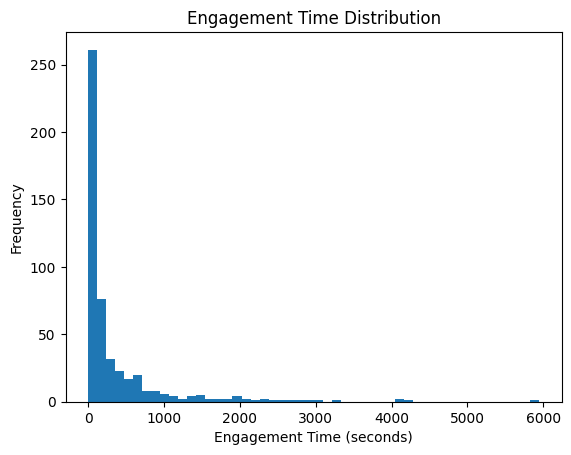

In [20]:
import matplotlib.pyplot as plt

plot = df['event_params__engagement_time_seconds'].plot(kind='hist', bins=50, title='Engagement Time Distribution')
plt.xlabel('Engagement Time (seconds)')

In [21]:
# Ensure events are sorted per user
df_sorted = df.sort_values(by=['user_pseudo_id', 'event_datetime'])

# Compute time gap between events per user
df_sorted['time_diff'] = df_sorted.groupby('user_pseudo_id')['event_datetime'].diff()

# Use 6-minute timeout
SESSION_TIMEOUT = pd.Timedelta(minutes=6)

# Define inferred session ID using 6-minute gaps
df_sorted['inferred_session_id'] = (
    (df_sorted['time_diff'] > SESSION_TIMEOUT) | df_sorted['time_diff'].isna()
).cumsum()

# Aggregate inferred sessions
session_times = df_sorted.groupby(['user_pseudo_id', 'inferred_session_id'])['event_datetime'].agg(['min', 'max'])
session_times['session_screen_time_seconds'] = (session_times['max'] - session_times['min']).dt.total_seconds()
session_times = session_times[session_times['session_screen_time_seconds'] > 0]
session_times = session_times.reset_index()

session_times = session_times.rename(columns={'min': 'date_time'})
session_times['local_datetime'] = session_times['date_time'] + pd.to_timedelta(df_sorted['device__time_zone_offset_hours'].fillna(0), unit='h')

session_times['local_date'] = session_times['local_datetime'].dt.normalize()
ts_weekday = session_times['local_datetime'].dt.day_name()
session_times['ts_weekday'] = pd.Categorical(ts_weekday, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
session_times['ts_is_weekend'] = session_times['ts_weekday'].isin(['Saturday', 'Sunday']) # is weekend

session_times['local_time'] = session_times['local_datetime'].dt.time 
session_times['ts_hour'] = session_times['local_datetime'].dt.hour
session_times['ts_daytime_named'] = session_times['ts_hour'].apply(lambda x: 
                                             'night' if (x < 6 or x > 22) else 
                                             'morning' if x < 11 else 
                                             'noon' if x < 14 else 
                                             'afternoon' if x < 17 else 
                                             'evening') # time group of day

session_times = session_times[['inferred_session_id', 'session_screen_time_seconds', 'date_time', 'local_datetime', 'local_date', 'local_time', 'ts_weekday', 'ts_is_weekend', 'ts_hour', 'ts_daytime_named', 'user_pseudo_id']]



In [22]:
session_times.to_parquet('./data/inferred_sessions.parquet', index=False)

In [23]:
session_times.head()

,inferred_session_id,session_screen_time_seconds,date_time,local_datetime,local_date,local_time,ts_weekday,ts_is_weekend,ts_hour,ts_daytime_named,user_pseudo_id
0,2,134.130000,2025-04-23 09:43:57.787000+00:00,2025-04-23 12:43:57.787000+00:00,2025-04-23 00:00:00+00:00,12:43:57.787000,Wednesday,False,12,noon,0bca8b790da023aedaafd11d19926b24
1,4,3.001001,2025-04-05 23:17:34.236000+00:00,2025-04-06 02:17:34.236000+00:00,2025-04-06 00:00:00+00:00,02:17:34.236000,Sunday,True,2,night,101d6353e3055417915530f5821a8423
2,5,263.043002,2025-04-08 21:14:36.852000+00:00,2025-04-09 00:14:36.852000+00:00,2025-04-09 00:00:00+00:00,00:14:36.852000,Wednesday,False,0,night,10b094caaf62a0dfbe832e4c8f016af9
3,6,1847.613219,2025-04-09 07:13:09.629000+00:00,2025-04-09 10:13:09.629000+00:00,2025-04-09 00:00:00+00:00,10:13:09.629000,Wednesday,False,10,morning,10b094caaf62a0dfbe832e4c8f016af9
4,7,123.714021,2025-04-09 07:53:44.944000+00:00,2025-04-09 10:53:44.944000+00:00,2025-04-09 00:00:00+00:00,10:53:44.944000,Wednesday,False,10,morning,10b094caaf62a0dfbe832e4c8f016af9


In [24]:
session_times.describe()

,inferred_session_id,session_screen_time_seconds,ts_hour
count,205.000000,205.000000,205.000000
mean,126.478049,887.736329,14.297561
std,68.775036,1245.969152,5.903990
min,2.000000,0.042001,0.000000
25%,68.000000,107.062011,11.000000
50%,131.000000,356.729000,15.000000
75%,183.000000,1242.749000,19.000000
max,243.000000,6999.541120,23.000000


In [25]:
# Define table names
main_table_id = f"{PROJECT_ID}.{DATASET_ID}.clean_data"
sessions_table_id = f"{PROJECT_ID}.{DATASET_ID}.inferred_sessions"

try:
    # Upload main event data
    main_job = bq_client.load_table_from_dataframe(
        df,
        main_table_id,
        job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
    )
    main_job.result()  # Wait for main job to finish

    print(f"Cleaned event data written to {main_table_id}")

    # Upload session summary
    sessions_job = bq_client.load_table_from_dataframe(
        session_times,
        sessions_table_id,
        job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
    )
    sessions_job.result()  # Wait for sessions job to finish

    print(f"Session durations written to {sessions_table_id}")
    print("Data processing and upload completed successfully.")
except GoogleAPICallError as api_error:
    print(f"API error occurred: {api_error}")
except RetryError as retry_error:
    print(f"Retry error occurred: {retry_error}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Cleaned event data written to emojioracle-342f1.analytics_481352676.clean_data
Session durations written to emojioracle-342f1.analytics_481352676.inferred_sessions
Data processing and upload completed successfully.


In [28]:
df['event_params__menu_name'].value_counts()

event_params__menu_name
scroll_menu               1703
crystal_menu               946
shop_menu                  648
board_menu                 564
wanna_play_menu            379
crystal_character_menu     295
energy_gold_exchange       226
crystal_cauldron_menu      163
crystal_aliginn_menu       115
crystal_coffee_menu         95
crystal_energy_menu         86
wheel_of_fortune            43
ScrollMenu                   2
Name: count, dtype: int64